## Evaluation on Ground truth data

In [48]:
import os
import time as t
import numpy as np
import math


from tqdm import tqdm
import matplotlib.pyplot as plt

from PIL import Image

from utils import *
from numerics import *

In [55]:
def filter_and_summarize_velocities(amp, corr, peak, flow_x, flow_y):
    
    min_corr_value = 0.2 
    # 2. Mean velocity with filtering on the correlation coefficient
    filtered_corr = np.where(corr > min_corr_value, 1, 0)


    # 3. Mean velocity with filtering on velocities
    perc_filtering_threshold = 0.5
    amp_mean_truth = 8
    min_vel_in_pixels = (1.0 - perc_filtering_threshold)*amp_mean_truth
    max_vel_in_pixels = (1.0 + perc_filtering_threshold)*amp_mean_truth
    filtered_amp_seq = np.where(np.all([amp > min_vel_in_pixels, amp < max_vel_in_pixels, np.abs(flow_x) > np.abs(flow_y)], axis=0), amp, 0)


    # 4. Mean velocity with filtering on local peak height
    filtered_peak = np.where(peak > corr / 2.0, 1, 0)

   
    # 5. Mean velocity with filtering on all constraints
    
    filtered_all = vec_mul3(filtered_amp_seq,filtered_corr,filtered_peak)
   
    
    del filtered_corr, filtered_amp_seq, filtered_peak
    
    return filtered_all 


In [59]:
#gt_path = 'y:\\projects\\pn-reduction\\farago\\result\\watershed-gt-scan-dense-oy-300\\'
#res_path = 'y:\\projects\\pn-reduction\\ershov\\exp_div\\exp_div_par_300\\'

datasets = ['300', '400', '500', '600']
#datasets = ['300']



In [60]:
for dt in datasets:
    
    dataset = dt
    
    print('Dataset:', dataset)
    
    gt_path = '/mnt/LSDF/projects/pn-reduction/farago/result/watershed-gt-scan-dense-oy-' + dataset + '/'
    res_path = '/mnt/LSDF/projects/pn-reduction/ershov/exp_div/exp_div_par_' + dataset + '/'
    
    # Read ground truth flow
    gtx_orig = read_images_from_directory_statusbar(gt_path, 'fo-'+dataset+'-gt-2')
    gty_orig = read_images_from_directory_statusbar(gt_path, 'fo-'+dataset+'-gt-1')
    
    # Correct rotation and components to match coordinates
    gtx = - np.rot90(gty_orig, 3, axes=(1,2))
    gty = np.rot90(gtx_orig, 3, axes=(1,2))
    gta = np.sqrt(gtx**2 + gty**2)
    
    # Read computed autocorrelation results
    
    p = res_path + 'exp_div_Tile_d'+dataset
    
    vx = read_tiff(p +'_flow_x_seq.tif', 200)
    vy = read_tiff(p +'_flow_y_seq.tif', 200)
    va = np.sqrt(vx**2 + vy**2)
    
    corr = read_tiff(p + '_corr_seq.tif', 200)
    peak = read_tiff(p + '_peak_seq.tif', 200)
    
    # Filtered results (valid according to the filtering procedure)
    filtered = filter_and_summarize_velocities(va, corr, peak, vx, vy)
    
    # Consider indexes which are both valid in ground truth and filtered results
    ids = np.nonzero(gta*filtered)

    diff_mean_amp = np.mean(np.abs(gta[ids] - va[ids]))
    diff_std_amp = np.std(np.abs(gta[ids] - va[ids]))
    
    print('Mean error:', diff_mean_amp)
    print('Std of error:', diff_std_amp)
    

 38%|███▊      | 55/144 [00:00<00:00, 544.17it/s]

('Dataset:', '300')


100%|██████████| 144/144 [00:00<00:00, 459.29it/s]


('Mean error:', 0.20283465)
('Std of error:', 0.33984092)
('Dataset:', '400')


100%|██████████| 144/144 [00:00<00:00, 234.24it/s]


('Mean error:', 0.15481395)
('Std of error:', 0.3400629)
('Dataset:', '500')


100%|██████████| 144/144 [00:00<00:00, 234.31it/s]


('Mean error:', 0.12056734)
('Std of error:', 0.33055094)
('Dataset:', '600')


100%|██████████| 144/144 [00:00<00:00, 234.73it/s]


('Mean error:', 0.11574425)
('Std of error:', 0.31477126)


In [20]:
print(len(gtx_orig))
print(len(vx))

144
144


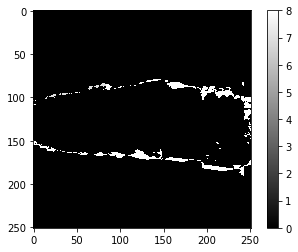

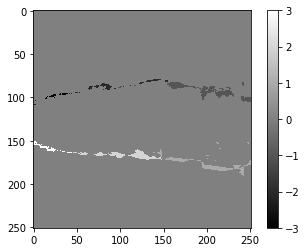

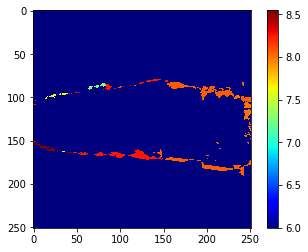

In [33]:
imx = gtx[0]
imy = gty[0]
ima = gta[0]

plt.imshow(imx, cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(imy, cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(ima, vmin=6, cmap='jet')
plt.colorbar()
plt.show()


In [41]:
ids = np.nonzero(gta)

diff_mean_amp = np.mean(np.abs(gta[ids] - va[ids]))
diff_std_amp = np.std(np.abs(gta[ids] - va[ids]))

In [43]:
print('Mean error:', diff_mean_amp)
print('Std of error:', diff_std_amp)

('Mean error:', 1.180505)
('Std of error:', 2.1500726)
